kaggle competition: https://www.kaggle.com/competitions/feedback-prize-effectiveness

# Library

In [1]:
!pip install transformers
!pip install sentencepiece
import numpy as np
import torch
import random
import os
import json
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import math
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
import os
from sklearn import metrics
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from torchvision import transforms
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c feedback-prize-effectiveness

# unzip dataset
import zipfile
def un_zipFiles(path):
    files=os.listdir(path)
    for file in files:
        if file.endswith('.zip'):
            filePath=path+'/'+file
            zip_file = zipfile.ZipFile(filePath)
            for names in zip_file.namelist():
                zip_file.extract(names,path)
            zip_file.close() 
un_zipFiles('../content/')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/8.13M [00:00<?, ?B/s]
100% 8.13M/8.13M [00:00<00:00, 191MB/s]


In [2]:
import sentencepiece
import json
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset 
from transformers import AdamW
from transformers import AutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed for reproducibility
def same_seeds(seed):
	  torch.manual_seed(seed)
	  if torch.cuda.is_available():
		    torch.cuda.manual_seed(seed)
		    torch.cuda.manual_seed_all(seed)
	  np.random.seed(seed)
	  random.seed(seed)
	  torch.backends.cudnn.benchmark = False
	  torch.backends.cudnn.deterministic = True
same_seeds(125)

In [3]:
fp16_training = True

if fp16_training:
    !pip install accelerate
    from accelerate import Accelerator
    accelerator = Accelerator(fp16=True)
    device = accelerator.device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# model

In [4]:
class AttentionHead(nn.Module):
    def __init__(self, in_size: int = 768, hidden_size: int = 512) -> None:
        super().__init__()
        self.W = nn.Linear(in_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)
        output = self.dropout(context_vector)
        return output


class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


class FeedbackModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
     
        self.model_name = model_name
        
        self.num_labels = num_labels
      

        hidden_dropout_prob: float = 0.1
        layer_norm_eps: float = 1e-7

        config = AutoConfig.from_pretrained(model_name)

        config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout_prob": hidden_dropout_prob,
                "layer_norm_eps": layer_norm_eps,
                "add_pooling_layer": False,
                "num_labels": self.num_labels,
            }
        )
        self.transformer = AutoModel.from_pretrained(model_name, config=config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout4 = nn.Dropout(0.4)
        self.dropout5 = nn.Dropout(0.5)
        # self.attention = AttentionHead(in_size=config.hidden_size, hidden_size=config.hidden_size)
        self.pooler = MeanPooling()
        self.output = nn.Linear(config.hidden_size, self.num_labels)

    
    def loss(self, outputs, targets):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(outputs, targets)
        return loss

    
    def forward(self, ids, mask, token_type_ids=None, targets=None):

        if token_type_ids:
            transformer_out = self.transformer(ids, mask, token_type_ids)
        else:
            transformer_out = self.transformer(ids, mask)
        # sequence_output = transformer_out.pooler_output
        sequence_output = transformer_out.last_hidden_state
        # sequence_output = self.attention(sequence_output)
        sequence_output = self.pooler(sequence_output, mask)
        sequence_output = self.dropout(sequence_output)

        logits1 = self.output(self.dropout1(sequence_output))
        logits2 = self.output(self.dropout2(sequence_output))
        logits3 = self.output(self.dropout3(sequence_output))
        logits4 = self.output(self.dropout4(sequence_output))
        logits5 = self.output(self.dropout5(sequence_output))

        logits = (logits1 + logits2 + logits3 + logits4 + logits5) / 5
        logits = torch.softmax(logits, dim=-1)
        loss = 0

        if targets is not None:
            loss1 = self.loss(logits1, targets)
            loss2 = self.loss(logits2, targets)
            loss3 = self.loss(logits3, targets)
            loss4 = self.loss(logits4, targets)
            loss5 = self.loss(logits5, targets)
            loss = (loss1 + loss2 + loss3 + loss4 + loss5) / 5

            return logits, loss

        return logits, loss, {}

# Helper

In [5]:
!pip install -q bitsandbytes-cuda112
import bitsandbytes as bnb

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"
        
        if hasattr(embeddings_path, attr_name): 
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters





# Data

In [6]:
from pandas.core.arrays import masked
from joblib import Parallel, delayed
def _prepare_training_data_helper(tokenizer, df, is_train):
    training_samples = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        idx = row["essay_id"]
        discourse_text = row["essay_text"][row['discourse_text_span'][0]:row['discourse_text_span'][1]]
        discourse_type = row["discourse_type"]
        text = row['essay_text']
        encoded_type = tokenizer.encode_plus(
            tokenizer.cls_token + discourse_type.lower() + ' ',
            add_special_tokens=False,
            return_tensors='pt'
        )
        encoded_text = tokenizer.encode_plus(
            discourse_text.lower() + tokenizer.sep_token,
            add_special_tokens=False,
            return_tensors='pt'
        )
        encoded_essay_before = tokenizer.encode_plus(
            text[:row['discourse_text_span'][0]].lower(),
            add_special_tokens=False,
            return_tensors='pt'
        )
        encoded_essay_after = tokenizer.encode_plus(
            text[row['discourse_text_span'][1]:].lower(),
            add_special_tokens=False,
            return_tensors='pt'
        )

        input_ids = torch.concat((
            encoded_type['input_ids'].reshape(-1),
            encoded_text['input_ids'].reshape(-1),
            encoded_essay_before['input_ids'].reshape(-1),
            encoded_text['input_ids'].reshape(-1)[:-1],
            encoded_essay_after['input_ids'].reshape(-1)),
            dim=0)

        sample = {
            "discourse_id": row["discourse_id"],
            "input_ids": input_ids,
            # "discourse_text": discourse_text,
            # "essay_text": text,
            # "mask": encoded_text["attention_mask"],
        }

        #if "token_type_ids" in encoded_text:
        #    sample["token_type_ids"] = encoded_text["token_type_ids"]

        label = row["discourse_effectiveness"]

        sample["label"] = LABEL_MAPPING[label]
        sample['start'] = encoded_type['input_ids'].reshape(-1).shape[0]
        sample['end'] = encoded_type['input_ids'].reshape(-1).shape[0] + encoded_text['input_ids'].reshape(-1).shape[0] - 1
        sample['essay_start'] = encoded_essay_before['input_ids'].reshape(-1).shape[0] + sample['end'] + 1
        sample['essay_end'] = sample['essay_start'] + encoded_text['input_ids'].reshape(-1).shape[0] - 1 
        training_samples.append(sample)
    return training_samples


def prepare_training_data(df, tokenizer, num_jobs, is_train):
    training_samples = []

    df_splits = np.array_split(df, num_jobs)

    results = Parallel(n_jobs=num_jobs, backend="multiprocessing")(
        delayed(_prepare_training_data_helper)(tokenizer, df, is_train) for df in df_splits
    )
    for result in results:
        training_samples.extend(result)

    return training_samples

def random_mask(ids ,start, end, essay_start, essay_end, prop,tokenizer):
        text_len = end - start
        mask_index = np.random.uniform(size=text_len) < prop
        ids[start:end][mask_index] = tokenizer.mask_token_id
        ids[essay_start:essay_end][mask_index] = tokenizer.mask_token_id
        mask = np.array([1] * len(ids))
        mask[start:end][mask_index] = 0
        mask[essay_start:essay_end][mask_index] = 0
        return [ids, mask]

class FeedbackDataset:
    def __init__(self, samples, max_len, tokenizer,prop):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.prop = prop
    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        ids = self.samples[idx]["input_ids"]
        label = self.samples[idx]["label"]
        start = self.samples[idx]["start"]
        end = self.samples[idx]["end"]
        essay_start = self.samples[idx]['essay_start']
        essay_end = self.samples[idx]['essay_end']
        input_ids = np.array(ids.reshape(-1))
        output = random_mask(input_ids,start,end,essay_start, essay_end, self.prop, self.tokenizer)
        input_ids = output[0].tolist()
        mask = output[1].tolist()
        if len(input_ids) > self.max_len - 1:
            input_ids = input_ids[: self.max_len - 1]
            mask = mask[: self.max_len - 1]
        input_ids = input_ids + [self.tokenizer.sep_token_id]
        mask = mask + [1]
        return {
            "ids": input_ids,
            "mask": mask,
            #"token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": label,
        }


class Collate:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        

    def __call__(self, batch):
        output = dict()
        output["ids"] = [sample["ids"] for sample in batch]
        output["mask"] = [sample["mask"] for sample in batch]
        output["targets"] = [sample["targets"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["ids"]]
            output["mask"] = [s + (batch_max - len(s)) * [0] for s in output["mask"]]
        else:
            output["ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["ids"]]
            output["mask"] = [(batch_max - len(s)) * [0] + s for s in output["mask"]]

        # convert to tensors
        output["ids"] = torch.tensor(output["ids"], dtype=torch.long)
        output["mask"] = torch.tensor(output["mask"], dtype=torch.long)
        output["targets"] = torch.tensor(output["targets"], dtype=torch.long)

        return output

In [7]:
import copy
def get_substring_span(text, substring, min_length=10, fraction=0.999):
    """
    Returns substring's span from the given text with the certain precision.
    """

    position = text.find(substring)
    substring_length = len(substring)
    if position == -1:
        half_length = int(substring_length * fraction) 
        half_substring = substring[:half_length]
        half_substring_length = len(half_substring)
        if half_substring_length < min_length:
            return [-1, 0]
        else:
            return get_substring_span(text=text, 
                                    substring=half_substring, 
                                    min_length=min_length, 
                                    fraction=fraction)

    span = [position, position+substring_length]
    return span


def read_file(path):
    with open(path, "r") as file:
        data = file.read()

    return data

def preprocess(data_frame, 
               essay_id_column="essay_id", 
               essay_path_column="essay_path", 
               essay_text_column="essay_text", 
               discourse_text_column="discourse_text", 
               compute_lengths=True, 
               directory="./", 
               file_format="txt"):

    data_frame = copy.deepcopy(data_frame)

    data_frame[essay_path_column] = data_frame[essay_id_column].apply(lambda essay_id: os.path.join(directory, f"{essay_id}.{file_format}"))
    data_frame[essay_text_column] = data_frame[essay_path_column].apply(lambda essay_path: read_file(essay_path))

    data_frame[f"{discourse_text_column}_span"] = data_frame.apply(lambda sample: get_substring_span(text=sample[essay_text_column], 
                                                                                                     substring=sample[discourse_text_column]), axis=1)
    if compute_lengths:
        data_frame[f"{essay_text_column}_length"] = data_frame[essay_text_column].apply(lambda text: len(text.split()))
        data_frame[f"{discourse_text_column}_length"] = data_frame[discourse_text_column].apply(lambda text: len(text.split()))

    return data_frame

In [8]:
train_path = "../content/train.csv"
train_directory = "../content/train"

df = pd.read_csv(train_path)
df = preprocess(data_frame=df, directory=train_directory, compute_lengths=True)

In [9]:
from sklearn import model_selection

LABEL_MAPPING = {"Ineffective": 0, "Adequate": 1, "Effective": 2}
l=[]
for i in df['discourse_effectiveness']:
    l.append(LABEL_MAPPING[i])

df['label_encoded'] = l

def create_folds(data, num_splits):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # I create a variable so we can stratify on discourse type and effectiveness score at the same time
    data['discourse_type_score'] = data['discourse_type'] + '_' + data['discourse_effectiveness']
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedGroupKFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data['discourse_type_score'].values, groups=data['essay_id'])):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("discourse_type_score", axis=1)

    # return dataframe with folds
    return data

df = create_folds(df, num_splits=5)

## Weight

In [ ]:
(df['discourse_effectiveness'].groupby(df['discourse_effectiveness']).count())/len(df)

discourse_effectiveness
Adequate       0.570570
Effective      0.253665
Ineffective    0.175765
Name: discourse_effectiveness, dtype: float64

In [ ]:
class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(df['label_encoded']),y=df['label_encoded'].to_numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)

# Train

In [10]:

from logging import critical
import transformers
num_epoch = 5 
validation = True
logging_step = 2000
learning_rate = 3e-6
gradient_accumulation_steps = 16

path = '../content'
max_len = 1024
NUM_JOBS = 12
train_batch_size = 1
model_name = 'microsoft/deberta-v3-large'

for fold in range(0,1):
    model = FeedbackModel(model_name,3)
    model = model.cuda()

    freeze(model.transformer.embeddings)
    freeze(model.transformer.encoder.layer[:2])

    model_parameters = filter(lambda parameter: parameter.requires_grad, model.parameters())

    # initializing optimizer
    optimizer = AdamW(params = model_parameters, lr=learning_rate) 
    #optimizer = bnb.optim.AdamW(params=model_parameters, lr=learning_rate, optim_bits=8)
    
 
    #set_embedding_parameters_bits(embeddings_path=model.transformer.embeddings)

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_df = df[df["kfold"] != fold].reset_index(drop=True)
    valid_df = df[df["kfold"] == fold].reset_index(drop=True)

    training_samples = prepare_training_data(train_df, tokenizer, num_jobs=NUM_JOBS, is_train=True)
    valid_samples = prepare_training_data(valid_df, tokenizer, num_jobs=NUM_JOBS, is_train=True)

    training_samples = list(sorted(training_samples, key=lambda d: len(d["input_ids"])))
    valid_samples = list(sorted(valid_samples, key=lambda d: len(d["input_ids"])))

    train_dataset = FeedbackDataset(training_samples, max_len, tokenizer,0.1)
    valid_dataset = FeedbackDataset(valid_samples, max_len, tokenizer,0)

    collate_fn = Collate(tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True,collate_fn=collate_fn)
    dev_loader = DataLoader(valid_dataset, batch_size=train_batch_size*4, shuffle=False, pin_memory=True,collate_fn=collate_fn)

    steps = len(train_loader)

    criterion = nn.CrossEntropyLoss().cuda()

    if fp16_training:
       model, optimizer, train_loader= accelerator.prepare(model, optimizer, train_loader) 

    schedular = transformers.get_linear_schedule_with_warmup(
        optimizer= optimizer,
        num_warmup_steps= 0,
        num_training_steps= len(train_loader) * num_epoch / gradient_accumulation_steps,
        )

    
    print("Start Training ...")
    bst_loss = {0:99,1:99,2:99,3:99,4:99}
    for epoch in range(num_epoch):

        train_loss = train_acc = 0
        model.train()

        for step, data in enumerate(tqdm(train_loader),1):	
            # Load all data into GPU
            data = [data[i].to(device) for i in data]
            label = data[2]
              
            logits = model(data[0],data[1],targets=label)
            loss =  logits[1]
            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps
            train_acc += (logits[0].argmax(axis=1).detach() == label).sum()
            train_loss += loss.detach()
            
            if fp16_training:
                accelerator.backward(loss)
            else:
                loss.backward()
            if step % gradient_accumulation_steps == 0 or step == steps:
                torch.nn.utils.clip_grad_norm_(model_parameters, 1)
                optimizer.step()
                model.zero_grad()
                schedular.step()

            
            # Print training loss and accuracy over past logging step
            if step % logging_step == 0:
                print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step * gradient_accumulation_steps}, acc = {train_acc / logging_step/train_batch_size}, learing_rate = {optimizer.param_groups[0]['lr']}")
                train_loss = train_acc = 0

            if validation and (step == len(train_loader) or step == len(train_loader) // 2):
                print("Evaluating Dev Set ...")
                model.eval()
                with torch.no_grad():
                    dev_acc = 0
                    dev_loss= 0 
                    for data in tqdm(dev_loader):
                        data = [data[i].to(device) for i in data]
                        label = data[2]
                    
                        logits = model(data[0],data[1],targets=label)
                        loss =  logits[1]
                        dev_acc += (logits[0].argmax(axis=1).detach() == label).sum()
                        dev_loss += loss.detach()
                    if dev_loss / len(dev_loader) < bst_loss[fold]:
                        bst_loss[fold] = dev_loss / len(dev_loader)
                        print("Saving Model ...")
                        model_save_dir = f"../content/drive/MyDrive/Leaf/bin/{fold}.bin" 
                        torch.save(model.state_dict(), model_save_dir)
                    print(f"Validation | Epoch {epoch + 1} | loss = {dev_loss / len(dev_loader)} | acc = {dev_acc / len(dev_loader)/ train_batch_size/4}")
                model.train()

    

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/pytho

Start Training ...


  0%|          | 0/29187 [00:00<?, ?it/s]

Epoch 1 | Step 2000 | loss = 0.8220791625976562, acc = 0.659000039100647, learing_rate = 2.9588858053242885e-06
Epoch 1 | Step 4000 | loss = 0.7691109008789062, acc = 0.6815000176429749, learing_rate = 2.9177716106485765e-06
Epoch 1 | Step 6000 | loss = 0.7710276489257812, acc = 0.6525000333786011, learing_rate = 2.876657415972865e-06
Epoch 1 | Step 8000 | loss = 0.72562109375, acc = 0.6915000081062317, learing_rate = 2.835543221297153e-06
Epoch 1 | Step 10000 | loss = 0.710154296875, acc = 0.6930000185966492, learing_rate = 2.7944290266214413e-06
Epoch 1 | Step 12000 | loss = 0.6961257934570313, acc = 0.6945000290870667, learing_rate = 2.7533148319457293e-06
Epoch 1 | Step 14000 | loss = 0.6835093383789063, acc = 0.7020000219345093, learing_rate = 2.7122006372700177e-06
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Saving Model ...
Validation | Epoch 1 | loss = 0.7121744155883789 | acc = 0.6857519745826721
Epoch 1 | Step 16000 | loss = 0.70288720703125, acc = 0.690000057220459, learing_rate = 2.6710864425943057e-06
Epoch 1 | Step 18000 | loss = 0.6897864379882812, acc = 0.7065000534057617, learing_rate = 2.6299722479185937e-06
Epoch 1 | Step 20000 | loss = 0.6818380737304688, acc = 0.706000030040741, learing_rate = 2.588858053242882e-06
Epoch 1 | Step 22000 | loss = 0.6766145629882813, acc = 0.7120000123977661, learing_rate = 2.54774385856717e-06
Epoch 1 | Step 24000 | loss = 0.6963646240234375, acc = 0.6915000081062317, learing_rate = 2.5066296638914585e-06
Epoch 1 | Step 26000 | loss = 0.6863023071289063, acc = 0.706000030040741, learing_rate = 2.4655154692157465e-06
Epoch 1 | Step 28000 | loss = 0.6429264526367188, acc = 0.7205000519752502, learing_rate = 2.424401274540035e-06
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Saving Model ...
Validation | Epoch 1 | loss = 0.6876844167709351 | acc = 0.6949868202209473


  0%|          | 0/29187 [00:00<?, ?it/s]

Epoch 2 | Step 2000 | loss = 0.6218386840820312, acc = 0.7305000424385071, learing_rate = 2.358618563058896e-06
Epoch 2 | Step 4000 | loss = 0.6160933837890625, acc = 0.7465000152587891, learing_rate = 2.3175043683831846e-06
Epoch 2 | Step 6000 | loss = 0.6197034912109375, acc = 0.7355000376701355, learing_rate = 2.2763901737074726e-06
Epoch 2 | Step 8000 | loss = 0.6086631469726562, acc = 0.7315000295639038, learing_rate = 2.235275979031761e-06
Epoch 2 | Step 10000 | loss = 0.6505680541992187, acc = 0.7325000166893005, learing_rate = 2.194161784356049e-06
Epoch 2 | Step 12000 | loss = 0.5974844970703125, acc = 0.7510000467300415, learing_rate = 2.1530475896803374e-06
Epoch 2 | Step 14000 | loss = 0.6191697387695313, acc = 0.7260000109672546, learing_rate = 2.1119333950046254e-06
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Validation | Epoch 2 | loss = 0.6877461075782776 | acc = 0.6949868202209473
Epoch 2 | Step 16000 | loss = 0.6145317993164062, acc = 0.7350000143051147, learing_rate = 2.0708192003289134e-06
Epoch 2 | Step 18000 | loss = 0.6313153686523437, acc = 0.7205000519752502, learing_rate = 2.029705005653202e-06
Epoch 2 | Step 20000 | loss = 0.6030257568359375, acc = 0.7405000329017639, learing_rate = 1.98859081097749e-06
Epoch 2 | Step 22000 | loss = 0.6123699951171875, acc = 0.7345000505447388, learing_rate = 1.9474766163017782e-06
Epoch 2 | Step 24000 | loss = 0.6237737426757812, acc = 0.7355000376701355, learing_rate = 1.9063624216260664e-06
Epoch 2 | Step 26000 | loss = 0.619380859375, acc = 0.7460000514984131, learing_rate = 1.8652482269503546e-06
Epoch 2 | Step 28000 | loss = 0.5707599487304688, acc = 0.7575000524520874, learing_rate = 1.8241340322746426e-06
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Validation | Epoch 2 | loss = 0.700179398059845 | acc = 0.694459080696106


  0%|          | 0/29187 [00:00<?, ?it/s]

Epoch 3 | Step 2000 | loss = 0.54652001953125, acc = 0.7610000371932983, learing_rate = 1.758351320793504e-06
Epoch 3 | Step 4000 | loss = 0.563861572265625, acc = 0.7625000476837158, learing_rate = 1.7172371261177923e-06
Epoch 3 | Step 6000 | loss = 0.558579833984375, acc = 0.7675000429153442, learing_rate = 1.6761229314420805e-06
Epoch 3 | Step 8000 | loss = 0.5412417602539062, acc = 0.7770000100135803, learing_rate = 1.6350087367663685e-06
Epoch 3 | Step 10000 | loss = 0.5716321411132812, acc = 0.7500000596046448, learing_rate = 1.5938945420906569e-06
Epoch 3 | Step 12000 | loss = 0.5472005615234375, acc = 0.7705000638961792, learing_rate = 1.5527803474149449e-06
Epoch 3 | Step 14000 | loss = 0.5603486328125, acc = 0.7600000500679016, learing_rate = 1.5116661527392333e-06
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Saving Model ...
Validation | Epoch 3 | loss = 0.6796550750732422 | acc = 0.6996042132377625
Epoch 3 | Step 16000 | loss = 0.5529828491210937, acc = 0.7660000324249268, learing_rate = 1.4705519580635215e-06
Epoch 3 | Step 18000 | loss = 0.5452992553710938, acc = 0.7710000276565552, learing_rate = 1.4294377633878097e-06
Epoch 3 | Step 20000 | loss = 0.5521205444335937, acc = 0.7720000147819519, learing_rate = 1.388323568712098e-06
Epoch 3 | Step 22000 | loss = 0.5590950927734375, acc = 0.7535000443458557, learing_rate = 1.3472093740363861e-06
Epoch 3 | Step 24000 | loss = 0.5460114135742188, acc = 0.7590000629425049, learing_rate = 1.3060951793606743e-06
Epoch 3 | Step 26000 | loss = 0.5401063232421875, acc = 0.7630000114440918, learing_rate = 1.2649809846849625e-06
Epoch 3 | Step 28000 | loss = 0.5726404418945312, acc = 0.7480000257492065, learing_rate = 1.2238667900092507e-06
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Saving Model ...
Validation | Epoch 3 | loss = 0.6777351498603821 | acc = 0.7023746967315674


  0%|          | 0/29187 [00:00<?, ?it/s]

Epoch 4 | Step 2000 | loss = 0.5146217041015625, acc = 0.7775000333786011, learing_rate = 1.1580840785281117e-06
Epoch 4 | Step 4000 | loss = 0.5160121459960938, acc = 0.7740000486373901, learing_rate = 1.1169698838524e-06
Epoch 4 | Step 6000 | loss = 0.4942028503417969, acc = 0.7890000343322754, learing_rate = 1.0758556891766884e-06
Epoch 4 | Step 8000 | loss = 0.5113108215332032, acc = 0.7800000309944153, learing_rate = 1.0347414945009766e-06
Epoch 4 | Step 10000 | loss = 0.5002211608886719, acc = 0.7875000238418579, learing_rate = 9.936272998252648e-07
Epoch 4 | Step 12000 | loss = 0.512400634765625, acc = 0.7905000448226929, learing_rate = 9.52513105149553e-07
Epoch 4 | Step 14000 | loss = 0.49347125244140627, acc = 0.7915000319480896, learing_rate = 9.113989104738411e-07
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Validation | Epoch 4 | loss = 0.7055652737617493 | acc = 0.6865435242652893
Epoch 4 | Step 16000 | loss = 0.533230224609375, acc = 0.768500030040741, learing_rate = 8.702847157981293e-07
Epoch 4 | Step 18000 | loss = 0.49164373779296877, acc = 0.7905000448226929, learing_rate = 8.291705211224175e-07
Epoch 4 | Step 20000 | loss = 0.501941650390625, acc = 0.7945000529289246, learing_rate = 7.880563264467057e-07
Epoch 4 | Step 22000 | loss = 0.4881549682617187, acc = 0.7975000143051147, learing_rate = 7.469421317709939e-07
Epoch 4 | Step 24000 | loss = 0.5141559448242188, acc = 0.7925000190734863, learing_rate = 7.058279370952822e-07
Epoch 4 | Step 26000 | loss = 0.49691439819335936, acc = 0.7915000319480896, learing_rate = 6.647137424195704e-07
Epoch 4 | Step 28000 | loss = 0.5180263671875, acc = 0.7780000567436218, learing_rate = 6.235995477438586e-07
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Validation | Epoch 4 | loss = 0.6835401058197021 | acc = 0.704617440700531


  0%|          | 0/29187 [00:00<?, ?it/s]

Epoch 5 | Step 2000 | loss = 0.48713702392578123, acc = 0.7865000367164612, learing_rate = 5.578168362627197e-07
Epoch 5 | Step 4000 | loss = 0.46842050170898436, acc = 0.8030000329017639, learing_rate = 5.167026415870079e-07
Epoch 5 | Step 6000 | loss = 0.4638617858886719, acc = 0.8035000562667847, learing_rate = 4.7558844691129613e-07
Epoch 5 | Step 8000 | loss = 0.448352783203125, acc = 0.8175000548362732, learing_rate = 4.3447425223558434e-07
Epoch 5 | Step 10000 | loss = 0.4689502868652344, acc = 0.799500048160553, learing_rate = 3.933600575598726e-07
Epoch 5 | Step 12000 | loss = 0.4696373596191406, acc = 0.8040000200271606, learing_rate = 3.5224586288416075e-07
Epoch 5 | Step 14000 | loss = 0.47396646118164065, acc = 0.8030000329017639, learing_rate = 3.1113166820844895e-07
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Validation | Epoch 5 | loss = 0.7078706622123718 | acc = 0.696174144744873
Epoch 5 | Step 16000 | loss = 0.48775363159179685, acc = 0.7870000600814819, learing_rate = 2.700174735327372e-07
Epoch 5 | Step 18000 | loss = 0.471762939453125, acc = 0.8005000352859497, learing_rate = 2.2890327885702537e-07
Epoch 5 | Step 20000 | loss = 0.48892816162109376, acc = 0.7935000658035278, learing_rate = 1.877890841813136e-07
Epoch 5 | Step 22000 | loss = 0.4669528503417969, acc = 0.7970000505447388, learing_rate = 1.466748895056018e-07
Epoch 5 | Step 24000 | loss = 0.4862476806640625, acc = 0.799500048160553, learing_rate = 1.0556069482989002e-07
Epoch 5 | Step 26000 | loss = 0.4547947692871094, acc = 0.812000036239624, learing_rate = 6.444650015417823e-08
Epoch 5 | Step 28000 | loss = 0.4583015441894531, acc = 0.8045000433921814, learing_rate = 2.333230547846644e-08
Evaluating Dev Set ...


  0%|          | 0/1895 [00:00<?, ?it/s]

Validation | Epoch 5 | loss = 0.6999455094337463 | acc = 0.7035620212554932


# Xgb

In [ ]:
import sklearn as sk
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from time import time
import xgboost as xgb
import datetime
from sklearn.metrics import confusion_matrix as cm, recall_score as recall, roc_auc_score as auc, accuracy_score as accuracy

In [ ]:
model = FeedBackModelAuto('distilbert-base-uncased-finetuned-sst-2-english')
p = torch.load('../content/drive/MyDrive/Leaf/bin/0.bin')
model.load_state_dict(p)
model.model.classifier = nn.Sequential()
model.model.dropout = nn.Sequential()
model = model.cuda()
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
train_df = df[df['fold'] !=  0].reset_index(drop=True)
valid_df = df[df['fold'] == 0].reset_index(drop=True)

train_tokenized = []
for text in tqdm(range(len(train_df))):
    lines = train_df['discourse_text'][text] 
    types = train_df['discourse_type'][text]
    tokenized = tokenizer(lines, add_special_tokens=False)
    tokenized_types = tokenizer(types, add_special_tokens=True)
    tokenized['input_ids'] = tokenized_types['input_ids'] + tokenized['input_ids'] + [102] 
    train_tokenized.append(tokenized)


dev_tokenized = []
for text in tqdm(range(len(valid_df))):
    lines = valid_df['discourse_text'][text]
    types = valid_df['discourse_type'][text]  
    tokenized = tokenizer(lines, add_special_tokens=False)
    tokenized_types = tokenizer(types, add_special_tokens=True)
    tokenized['input_ids'] = tokenized_types['input_ids'] + tokenized['input_ids'] + [102] 
    dev_tokenized.append(tokenized)


train_set = FeedBack_Dataset(train_tokenized,train_df['label_encoded'])
dev_set = FeedBack_Dataset(dev_tokenized,valid_df['label_encoded'])

train_batch_size = 16

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=train_batch_size, shuffle=False, pin_memory=True)

  0%|          | 0/29412 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/7353 [00:00<?, ?it/s]

In [ ]:
model.eval()
out = torch.Tensor()
labels = torch.Tensor()
with torch.no_grad():
    for data in tqdm(train_loader):
        data = [i.to(device) for i in data]
        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)
        label = data[2]  
        output = model(data[0],data[1])
        logits = output[0]
        out = torch.cat((out,logits.detach().cpu()))
        labels = torch.cat((labels,label.cpu()))

  0%|          | 0/1839 [00:00<?, ?it/s]

In [ ]:
out_dev = torch.Tensor()
labels_dev = torch.Tensor()
with torch.no_grad():
    for data in tqdm(dev_loader):
        data = [i.to(device) for i in data]
        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)
        label = data[2]  
        output = model(data[0],data[1])
        logits = output[0]
        out_dev = torch.cat((out_dev,logits.detach().cpu()))
        labels_dev = torch.cat((labels_dev,label.cpu()))

  0%|          | 0/460 [00:00<?, ?it/s]

In [ ]:
train_state = pd.DataFrame(out.numpy())
train_state['label'] = labels.numpy()
class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(df['label_encoded']),y=df['label_encoded'].to_numpy())
w = []
for i in train_state.iloc[:,-1]:
    w.append(class_weights[int(i)])
train_state['weight'] = np.array(w)

In [ ]:
dev_state = pd.DataFrame(out_dev.numpy())
dev_state['label'] = labels_dev.numpy()

In [ ]:
dtrain = xgb.DMatrix(train_state.iloc[:,0:-2],train_state.iloc[:,-2],weight=train_state.iloc[:,-1])
dtest = xgb.DMatrix(dev_state.iloc[:,0:-1],dev_state.iloc[:,-1])

In [ ]:
def plott(x,y,train,dev):
    fig,ax = plt.subplots(1,figsize=(15,10))
    ax.grid()
    for i in range(len(x)):
        ax.plot(y,train[(i)*len(y):(i+1)*len(y)],label=f"train {x[i]}")
        ax.plot(y,dev[(i)*len(y):(i+1)*len(y)],label=f"dev {x[i]}")
    ax.legend(fontsize="xx-large")
    plt.show()

In [ ]:
def find_best(x,y,dev):
    dev= np.array(dev).reshape(len(x),len(y))
    ind = np.where(dev==dev.min())
    if ind[0].shape != (1,):
        ind = [ind[0][0],ind[1][0]]
    print(f'{x[ind[0].item()]}, {y[ind[1].item()]}',{dev.min()})
    

00:03:863754, train loss: 0.8147383015433104, dev loss: 0.8994628888975759
00:02:650349, train loss: 0.6077391551650466, dev loss: 0.8310821309310037
00:02:208211, train loss: 0.5886128311827966, dev loss: 0.837054882348283
00:02:181232, train loss: 0.5735294698952185, dev loss: 0.8364312162848389
00:02:182761, train loss: 0.5603292866339147, dev loss: 0.8409837537933588
00:02:177752, train loss: 0.5482907780097263, dev loss: 0.8469893751228913
00:02:176121, train loss: 0.537986331647587, dev loss: 0.8527507436876934
00:02:166915, train loss: 0.5266804157141783, dev loss: 0.8619769162373783
00:02:182873, train loss: 0.5150395079014178, dev loss: 0.8691164930037439
00:02:191416, train loss: 0.5073678428056292, dev loss: 0.8793289248323858
00:02:154941, train loss: 0.500973070461475, dev loss: 0.8892722875245168
00:02:179496, train loss: 0.4928447379287983, dev loss: 0.903480780866977
00:02:185366, train loss: 0.4859692400381826, dev loss: 0.9219790189464971
00:02:186856, train loss: 0.4

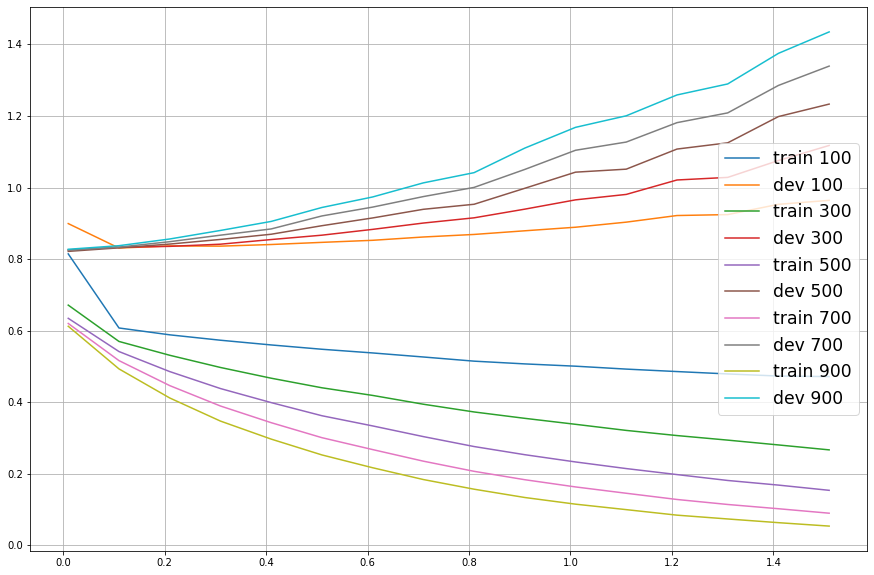

In [ ]:
from posixpath import join
num_round = 100
train_error = []
dev_error = [] 
x = np.arange(100,1000,200)
y = np.arange(0.01,1.52,0.1)

for i in x:
    for j in y:
        param = {'silent':True #并非默认
            ,'objective':"multi:softprob" #并非默认
            ,'num_class':3
            ,'eta':j
            ,'eval_metric':'mlogloss'
            ,'tree_method': 'gpu_hist'
            ,'max_depth':2
            ,'lambda':1
            ,'alpha':0.1
            #,'booster':'dart'
            #,'seed':j
            #,'gamma':j   
                }
        time0 = time()
        model = xgb.train(param, dtrain, i)
        pred1 = model.predict(dtrain)
        pred2 = model.predict(dtest)
        train_pred = pred1.copy()
        dev_pred = pred2.copy()
        
        train_loss = sklearn.metrics.log_loss(train_state.iloc[:,-2],train_pred)
        dev_loss = sklearn.metrics.log_loss(dev_state.iloc[:,-1],dev_pred)
        
        train_error.append(train_loss)
        dev_error.append(dev_loss)
        print(f'{datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f")}, train loss: {train_loss}, dev loss: {dev_loss}')
find_best(x,y,dev_error)
plott(x,y,train_error,dev_error)


In [ ]:
param = {'silent':True #并非默认
            ,'objective':"multi:softprob" #并非默认
            ,'num_class':3
            ,'eta':0.019
            ,'eval_metric':'mlogloss'
            ,'tree_method': 'gpu_hist'
            ,'max_depth':2
            ,'lambda':1
            ,'alpha':0.1
            ,'booster':'dart'
            #,'seed':j
            #,'gamma':j   
                }
model = xgb.train(param, dtrain, 220)

In [ ]:
pred1 = model.predict(dtrain)
pred2 = model.predict(dtest)
train_pred = pred1.copy()
dev_pred = pred2.copy()

train_loss = sklearn.metrics.log_loss(train_state.iloc[:,-2],train_pred)
dev_loss = sklearn.metrics.log_loss(dev_state.iloc[:,-1],dev_pred)

In [ ]:
dev_loss

0.8216342074209113

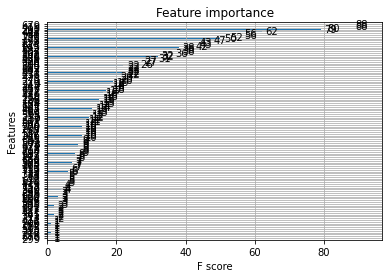

In [ ]:
xgb.plot_importance(model)

In [ ]:
model.save_model()

0.7169720227856077

In [ ]:
min(dev_error)

0.7476591101276231

In [ ]:
l = [8,6,5,8,9,1,5,8,7,5]

In [ ]:
index= np.array(l)np.array(l).reshape(2,5).min()

1

In [ ]:
l = np.array(l).reshape(2,5)

In [ ]:
l

array([8, 6, 5, 8, 9, 1, 5, 8, 7, 5])

In [ ]:
x=np.where(l==1)

In [ ]:
x[1].item()

0

In [ ]:
sklearn.metrics.log_loss(dev_state.iloc[:,-1],prob)

0.8334832959941559

In [ ]:
data = next(iter(train_loader))
data = [i.to(device) for i in data]

In [ ]:
out= model(data[0],data[1])

In [ ]:
out.shape

torch.Size([29412, 768])

In [ ]:
model.model.classifier = nn.Sequential()

In [ ]:
model.model.dropout = nn.Sequential()

In [ ]:
model

FeedBackModelAuto(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn

In [ ]:
print("Evaluating Dev Set ...")
model.eval()
with torch.no_grad():
    pred = []
    labels = []
    dev_acc = 0
    dev_loss= 0 
    for data in tqdm(dev_loader):
        data = [i.to(device) for i in data]
        label = data[2]
        labels.append(label)
        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)  
        output = model(input_ids=data[0],attention_mask=data[1])
        logits = output[0]
        pred.append(nn.functional.softmax(logits))
        loss =  criterion(logits,label) 
        dev_acc += (logits.argmax(axis=1).detach() == label).sum()
        dev_loss += loss.detach()
    print(f"Validation  | loss = {dev_loss / len(dev_loader)} | acc = {dev_acc / len(dev_loader)/ train_batch_size/2}")

Evaluating Dev Set ...


  0%|          | 0/920 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Validation  | loss = 0.7219251990318298 | acc = 0.645923912525177


In [ ]:
len(pred)

920

In [ ]:
len(labels)

920

In [ ]:
pred[0:5]

[tensor([[0.7614, 0.1065, 0.1321],
         [0.7535, 0.0294, 0.2171],
         [0.8001, 0.0334, 0.1665],
         [0.4706, 0.0128, 0.5166],
         [0.5336, 0.0152, 0.4512],
         [0.5024, 0.1265, 0.3710],
         [0.6463, 0.0287, 0.3250],
         [0.4705, 0.0892, 0.4403]], device='cuda:0'),
 tensor([[0.7878, 0.0284, 0.1839],
         [0.0590, 0.9353, 0.0057],
         [0.3006, 0.5512, 0.1482],
         [0.4853, 0.3780, 0.1367],
         [0.0267, 0.9675, 0.0058],
         [0.2942, 0.6878, 0.0180],
         [0.0315, 0.9631, 0.0054],
         [0.0442, 0.9544, 0.0013]], device='cuda:0'),
 tensor([[0.1106, 0.8828, 0.0066],
         [0.1139, 0.8800, 0.0061],
         [0.0400, 0.9575, 0.0024],
         [0.1068, 0.8878, 0.0054],
         [0.3698, 0.0111, 0.6190],
         [0.4208, 0.0082, 0.5709],
         [0.6773, 0.1521, 0.1706],
         [0.1239, 0.0032, 0.8728]], device='cuda:0'),
 tensor([[0.1861, 0.0017, 0.8122],
         [0.7879, 0.0929, 0.1192],
         [0.8383, 0.0407, 0.1210]

# Inference

In [ ]:
def inference(model_name,model_dict,data_loader):
    model = FeedbackModel(model_name,3)
    model.load_state_dict(model_dict)
    model = model.cuda()
    model.eval()
    out=[]
    with torch.no_grad():
        for data in tqdm(test_loader):
            data = [data[i].to(device) for i in data]          
            logits = model(data[0],data[1])
            logit = logits[0]
            prob = logit.detach().cpu().tolist()
            out += prob
            pred=torch.tensor(out)
    return pred

In [ ]:
from torch.distributed import distributed_c10d
df = pd.read_csv('../content/test.csv')
LABEL_MAPPING = {"Ineffective": 0, "Adequate": 1, "Effective": 2}

model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)

path = '../content'
max_len = 512
NUM_JOBS = 12
train_batch_size = 2
df.loc[:, "discourse_effectiveness"] = "Adequate"
test_samples = prepare_training_data(df, tokenizer, path, num_jobs=NUM_JOBS, is_train=False)

test_samples = list(sorted(test_samples, key=lambda d: len(d["input_ids"])))
list(sorted(test_samples, key=lambda d: len(d["input_ids"])))
test_dataset = FeedbackDataset(test_samples, max_len, tokenizer)
collate_fn = Collate(tokenizer)

test_loader = DataLoader(test_dataset, batch_size=train_batch_size*2, shuffle=False, pin_memory=True,collate_fn=collate_fn)

f0 = torch.load("../content/drive/MyDrive/Leaf/bin/0.bin")
f1 = torch.load("../content/drive/MyDrive/Leaf/bin/1.bin")
f2 = torch.load("../content/drive/MyDrive/Leaf/bin/2.bin")
f3 = torch.load("../content/drive/MyDrive/Leaf/bin/3.bin")
f4 = torch.load("../content/drive/MyDrive/Leaf/bin/4.bin")

pred0 = inference(model_name,f0,test_loader)
pred1 = inference(model_name,f1,test_loader)
pred2 = inference(model_name,f2,test_loader)
pred3 = inference(model_name,f3,test_loader)
pred4 = inference(model_name,f4,test_loader)

ids = []
for i in test_samples:
    j=i['discourse_id']
    ids.append(j)


output = pd.DataFrame()
output['discourse_id'] = ids
output['Ineffective'] = (pred0[:,0]+pred1[:,0]+pred2[:,0]+pred3[:,0]+pred4[:,0])/5
output['Adequate'] = (pred0[:,1]+pred1[:,1]+pred2[:,1]+pred3[:,1]+pred4[:,1])/5
output['Effective'] = (pred0[:,2]+pred1[:,2]+pred2[:,2]+pred3[:,2]+pred4[:,2])/5

output.to_csv('submission.csv',index=False)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3 [00:00<?, ?it/s]